# Subocean and CTD data merging + correction
The goal of this notebook is to show how the subocean data is currently beeing processed, and to have a base for asking the questions


# Questions:
Here a list of questions:

1) What could explain the difference between the *CH4 dissolved with water vapour* and *CH4 computed using standard values* ? (see section 2 a)

2) Are these equation still valid if we focus on N20 instead of CH4 ?

3) We still have the time delay to apply, what would be the equation ?

4) Does the temperature cell correction have been applied to the *CH4 measured ppm* ?

5) It would be useful to compare also the results with the A2PS software but I don't have CTD data in the .asc format, could you give me an example ?

6) I do not seem to have the correct equation to calculate the dissolved methane concentration (section 3), which one should i use ?



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

In [ ]:
!wget "https://raw.githubusercontent.com/hugocruzz/subocean/main/data/forel/Level0/CH4/SubOceanExperiment2024-07-03T12-47-08.txt" -O "SubOceanExperiment2024-07-03T12-47-08.txt"
!wget "https://raw.githubusercontent.com/hugocruzz/CTD_processing/main/data/Level0/Forel/20240703_1346_idronaut.txt" -O "20240703_1346_idronaut.txt"

--2025-02-21 10:33:08--  https://raw.githubusercontent.com/hugocruzz/subocean/main/data/forel/Level0/CH4/SubOceanExperiment2024-07-03T12-47-08.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2043498 (1.9M) [text/plain]
Saving to: ‘SubOceanExperiment2024-07-03T12-47-08.txt’

SubOceanExperiment2 100%[===================>]   1.95M  --.-KB/s    in 0.07s   

2025-02-21 10:33:09 (28.2 MB/s) - ‘SubOceanExperiment2024-07-03T12-47-08.txt’ saved [2043498/2043498]

--2025-02-21 10:33:09--  https://raw.githubusercontent.com/hugocruzz/CTD_processing/main/data/Level0/Forel/20240703_1346_idronaut.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.gith

Open the two datasets (subocean and ctd data)

In [ ]:
subocean_df = pd.read_csv(r"/content/SubOceanExperiment2024-07-03T12-47-08.txt", sep="\t")
ctd_df = pd.read_csv(r"/content/20240703_1346_idronaut.txt", sep='\s+').reset_index()

# Section 1: Preprocessing

We work with xarray as it'better for multidimensional data and interpolation, but it need some standardization on variable names

In [ ]:
# Rename columns with spaces to use underscores
subocean_df.columns = [col.replace(' ', '_').replace("(", "").replace(")", "").replace("[", "").replace("]", "") for col in subocean_df.columns]
ctd_df.columns = [col.replace(' ', '_') for col in ctd_df.columns]
ctd_ds = ctd_df.to_xarray()
subocean_ds = subocean_df.to_xarray()

We would like to make a match between the ctd and the subocean data, for that, we choose the pressure to be our matching coordinates variable. The profiles might not be done at the same time but can still be used.

In [ ]:
# prompt: Set the depth as coordinates of ctd_ds and subocean_ds and remove the original index

# Set 'Depth' as coordinate for both datasets and remove the original index
ctd_ds = ctd_ds.swap_dims({'index': 'Pres'})
ctd_ds = ctd_ds.set_coords('Pres')
ctd_ds = ctd_ds.drop_vars('index')
ctd_ds["Pres"] = ctd_ds["Pres"]*10 #Convert from dbar to bar

subocean_ds = subocean_ds.swap_dims({'index': 'Hydrostatic_Pressure_Calibrated_bar'})
subocean_ds = subocean_ds.set_coords('Hydrostatic_Pressure_Calibrated_bar')
subocean_ds = subocean_ds.drop_vars('index')


We do not want a two way profile, so we separate the downward and upward profile

In [ ]:
max_pressure_ctd = ctd_ds["Pres"].argmax()
ctd_ds_downard = ctd_ds.isel(Pres=slice(None, max_pressure_ctd.values))
max_pressure_subocean = subocean_ds["Hydrostatic_Pressure_Calibrated_bar"].argmax()
subocean_downard = subocean_ds.isel(Hydrostatic_Pressure_Calibrated_bar=slice(None, max_pressure_subocean.values))


Create the pressure grid

In [ ]:
# Define the pressure grid based on subocean_downard pressure data
pressure_grid = np.linspace(subocean_downard.Hydrostatic_Pressure_Calibrated_bar.min(),
                            subocean_downard.Hydrostatic_Pressure_Calibrated_bar.max(),
                            100)

In [ ]:
subocean_downard_unique = subocean_downard.groupby("Hydrostatic_Pressure_Calibrated_bar").mean()
ctd_ds_downard_unique = ctd_ds_downard.groupby("Pres").mean()

In [ ]:
subocean_interpolated = subocean_downard_unique.interp(Hydrostatic_Pressure_Calibrated_bar=pressure_grid)
ctd_interpolated = ctd_ds_downard_unique.interp(Pres=pressure_grid)

In [ ]:
#Rename "Pres" to "Hydrostatic_Pressure_Calibrated_bar"
ctd_interpolated = ctd_interpolated.rename({"Pres": "Hydrostatic_Pressure_Calibrated_bar"})
merged_ds = xr.merge([subocean_interpolated, ctd_interpolated])

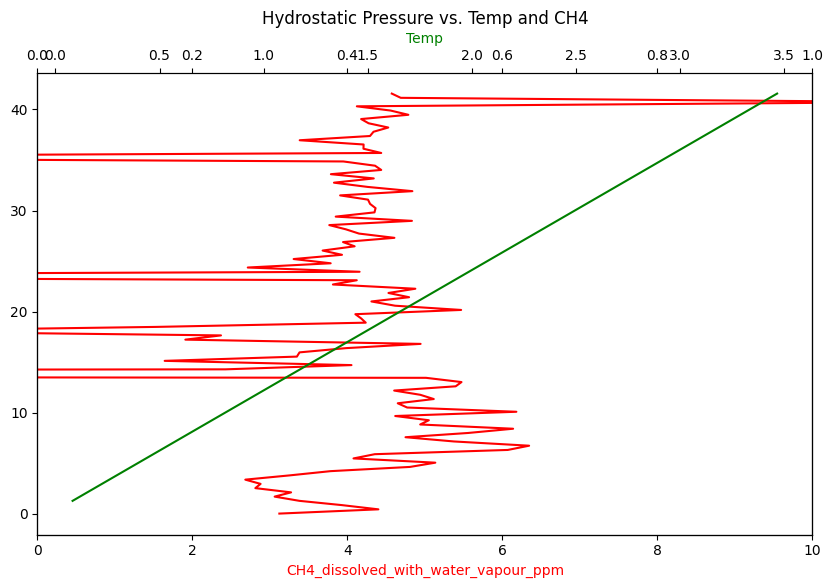

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Hydrostatic_Pressure_Calibrated_bar on the y-axis (reversed)
ax1.spines['top'].set_position(('outward', 60)) # Adjust position of the third x axis
ax1.plot(merged_ds.CH4_dissolved_with_water_vapour_ppm, merged_ds.Hydrostatic_Pressure_Calibrated_bar, color='r')
ax1.set_xlabel('CH4_dissolved_with_water_vapour_ppm', color='r')
ax1.set_xlim(0,10)
# Create a second x-axis
ax2 = ax1.twiny()
ax2.plot(merged_ds.Temp, merged_ds.Hydrostatic_Pressure_Calibrated_bar, color='g')
ax2.set_xlabel('Temp', color='g')

# Create a third x-axis
ax3 = ax1.twiny()

# Display the plot
plt.title('Hydrostatic Pressure vs. Temp and CH4')
plt.show()


# Seciton 2: CTD correction !

In [ ]:
def calc_meff_CH4(salinity: xr.DataArray=34, temperature: xr.DataArray=20, oxygen_pct: xr.DataArray=21) -> xr.DataArray:
  """
  Calculate membrane enrichment factor for CH4.
  Formula: meff_CH4 = (1.9774+(0.0385-0.00316*S)*(T-2.67))*(1+0.2286*(O2-0.2)/(0-0.2))

  Args:
      salinity (xr.DataArray): Salinity in PSU
      temperature (xr.DataArray): Water temperature in °C
      oxygen_pct (xr.DataArray): Dissolved oxygen in %

  Returns:
      xr.DataArray: Membrane enrichment factor (dimensionless)
  """
  BASE = 1.9774
  TEMP_COEF = 0.0385
  SAL_TEMP_COEF = -0.00316
  TEMP_OFFSET = 2.67
  O2_COEF = 0.2286
  O2_THRESHOLD = 0.2

  temp_component = (TEMP_COEF + SAL_TEMP_COEF * salinity) * (temperature - TEMP_OFFSET)
  o2_component = 1 + O2_COEF * (oxygen_pct - O2_THRESHOLD)/(0 - O2_THRESHOLD)

  return (BASE + temp_component) * o2_component


## a) Standard values recalculation check



Salinity = 34, temperature = 20 °C, DO = 0.21

In [ ]:
meff = calc_meff_CH4(34,20,0.21)
#Convert the float into a dimensional data (constant with pressure)
meff = meff +(merged_ds["CH4_measured_ppm"]*np.zeros(len(merged_ds["CH4_measured_ppm"])))
meff.attrs['units'] = 'dimensionless'
meff.attrs['long_name'] = 'Membrane enrichment factor for CH4 with standard values'


In [ ]:
merged_ds['meff_CH4_standard'] = meff
# Calculate membrane enrichment factor
Cgas = merged_ds["CH4_measured_ppm"]
Qcg = merged_ds["Flow_Carrier_Gas_sccm"]
Qtot = merged_ds["Total_Flow_sccm"]
C_h2o = merged_ds["H2O_measured_%"]/100

merged_ds["CH4_dissolved_with_water_vapor_ppm_standard_recalculated"] = 1/merged_ds["meff_CH4_standard"] * Cgas/(1-Qcg/Qtot - C_h2o)

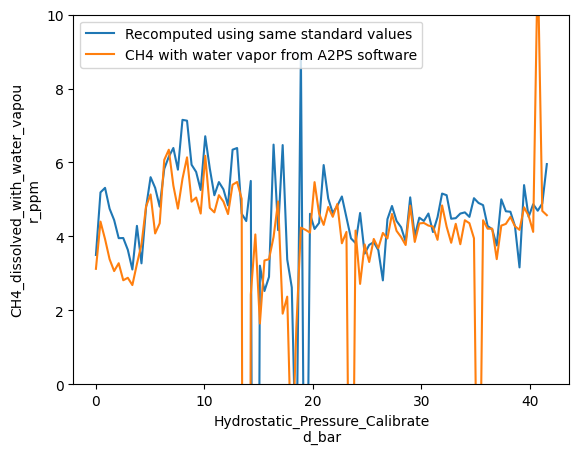

In [ ]:
merged_ds["CH4_dissolved_with_water_vapor_ppm_standard_recalculated"].plot(label="Recomputed using same standard values")
merged_ds["CH4_dissolved_with_water_vapour_ppm"].plot(label="CH4 with water vapor from A2PS software")
#Set y limits from 0 to 10
plt.ylim(0,10)
plt.legend()


## b) Using CTD data:

In [ ]:
meff = calc_meff_CH4(
  salinity=merged_ds['Sal'],
  temperature=merged_ds['Temp'],
  oxygen_pct=merged_ds['O2%']/100*0.21
        )
meff.attrs['units'] = 'dimensionless'
meff.attrs['long_name'] = 'Membrane enrichment factor for CH4 corrected with ctd profile'

In [ ]:
merged_ds['meff_CH4_ctd_correction'] = meff
merged_ds["CH4_dissolved_with_water_vapor_ctd_correction"] = 1/merged_ds["meff_CH4_ctd_correction"] * Cgas/(1-Qcg/Qtot - C_h2o)

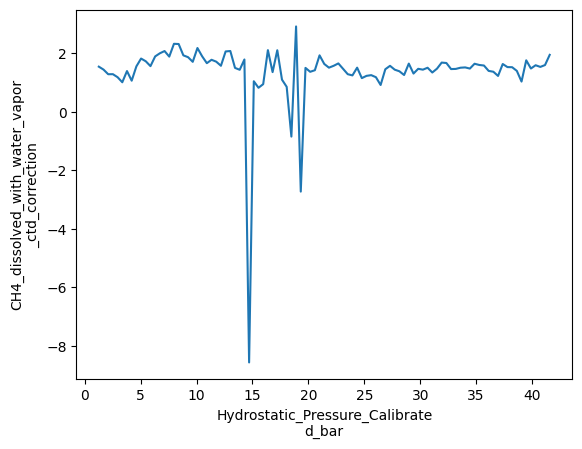

In [ ]:

merged_ds["CH4_dissolved_with_water_vapor_ctd_correction"].plot()

# Section 3: Convert into dissolved methane in water

I could not find the equation yet to solve this aspect (the equation below shows bad results)

In [ ]:
def calc_dissolved_CH4(ch4_gas_ppm: xr.DataArray,
                            temperature_c: xr.DataArray,
                            salinity: xr.DataArray,
                            pressure_bar: xr.DataArray) -> xr.DataArray:
    """
    Calculate dissolved methane concentration at 200m depth using Henry's law with pressure correction.

    Args:
        ch4_gas_ppm (xr.DataArray): CH4 concentration in gas phase (ppm)
        temperature_c (xr.DataArray): Water temperature (°C)
        salinity (xr.DataArray): Salinity (PSU)
        pressure_bar (xr.DataArray): Pressure at 200m depth (bar)

    Returns:
        xr.DataArray: Dissolved CH4 concentration (nmol/L)
    """
    # Convert temperature to Kelvin
    temperature_k = temperature_c + 273.15

    # Convert pressure to atm
    pressure_atm = pressure_bar *0.986923  / 1013.25

    # Weiss (1974) coefficients for methane solubility in seawater (mol/kg/atm)
    A1 = -68.8862
    B1 = 101.4956
    C1 = 28.7314

    # Calculate Henry's constant for methane (mol/kg/atm)
    henry_constant = np.exp(A1 + (B1 / temperature_k) + C1 * np.log(temperature_k)) * np.exp(-0.0432 * salinity)

    # Convert Henry's constant from mol/kg/atm to mol/L/atm (approximation for seawater density ~1 kg/L)
    henry_constant_mol_L_atm = henry_constant  # Since 1 kg ~ 1 L for seawater

    # Fugacity coefficient for methane (approximation, near 1 at low pressure, correct at high pressure)
    # Using a simple Peng-Robinson-type approximation
    fugacity_coefficient = 1 - (pressure_atm * 0.0001)  # Approximate correction factor
    fugacity_coefficient = np.maximum(fugacity_coefficient, 0.8)  # Avoid unphysical values

    # Calculate methane fugacity
    methane_fugacity = pressure_atm * fugacity_coefficient

    # Calculate dissolved methane concentration (mol/L)
    ch4_dissolved_mol_L = (ch4_gas_ppm / 1e6) * methane_fugacity / henry_constant_mol_L_atm

    # Convert to nmol/L
    ch4_dissolved_nmol_L = ch4_dissolved_mol_L * 1e9

    return ch4_dissolved_nmol_L

In [ ]:
CH4 = 4 #ppm
Temp = 3 # °C
Sal = 33
Pressure = 20
calc_dissolved_CH4(CH4, Temp, Sal, Pressure)

1.3506662130821136e-38

In [ ]:
merged_ds["CH4_nmol_L_dissolved_with_water_vapor_standard"] = calc_dissolved_CH4(merged_ds["CH4_dissolved_with_water_vapor_ppm_standard_recalculated"],
                                                                                 merged_ds["Temp"], merged_ds["Sal"],
                                                                                 merged_ds["Hydrostatic_Pressure_Calibrated_bar"]*1000) #Pressure in mbar

(0.0, 10.0)

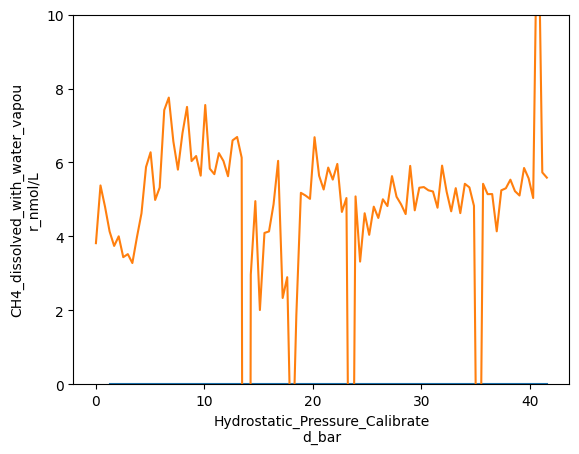

In [ ]:
merged_ds["CH4_nmol_L_dissolved_with_water_vapor_standard"].plot()
merged_ds["CH4_dissolved_with_water_vapour_nmol/L"].plot()
plt.ylim(0,10)

In [ ]:
merged_ds["CH4_nmol_L_dissolved_with_water_vapor_ctd_correction"] = calc_dissolved_CH4(merged_ds["CH4_dissolved_with_water_vapor_ctd_correction"],
                                                                                       merged_ds["Temp"], merged_ds["Sal"], merged_ds["Hydrostatic_Pressure_Calibrated_bar"])